In [12]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import sys
import copy 
from time import time

from astropy.table import Table, vstack

import numpy as np 
import emcee

import scipy.ndimage
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator

from astroML.stats import binned_statistic_2d

from cap_loess_2d import loess_2d
from cap_plot_velfield import plot_velfield

plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12.0
plt.rc('text', usetex=True)
    
from asap.asap_data_io import *
from asap.asap_model_setup import *
from asap.asap_utils import *
from asap.asap_run_model import * 
from asap.asap_model_prediction import *
from asap.asap_likelihood import * 
from asap.um_model_plot import *
from asap.full_mass_profile_model import *
from asap.asap_mass_model import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load model and data

In [3]:
config_file = 'test/asap_smdpl_mmax_m10_frac4_new_2.yaml'

cfg_ini = parse_config(config_file)

cfg, obs_data, um_data = initial_model(cfg_ini, verbose=True)

print(cfg['model_type'])

# Stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Weak lensing profile sample: s16a_wide2_massive_boxbin7_default
# Pre-computed SMF for inner logMs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_11.6.npy
# Pre-computed SMF for total logMs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: None
# Using logm_10 as inner stellar mass.
# Using logm_max as total stellar mass.
# There are 12 weak lensing profiles in this sample
# SMF for total stellar mass: 
  11.6000 -- 12.3000 in 7 bins
# SMF for inner stellar mass: 
  10.8000 -- 11.8000 in 10 bins
# Pre-computed full SMF: primus_smf_z0.3_0.4.fits
# For inner stellar mass: 
    10 bins at 10.80 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.60 < logMtot < 12.30
# The volume of the HSC data is    102060083.62 Mpc^3
# The volume of the UniverseMachine mock is    205348196.23 

In [4]:
um_mock = um_data['um_mock']

### New model 2

* Greymalkin
* Using `logmh_peak`
* `de` move
* 300 Walkers, 800 burn-in, 1000 steps

In [5]:
(mod_burnin_samples, 
 mod_burnin_chains, 
 mod_burnin_lnprob, 
 mod_burnin_best, _, _) = mcmc_load_results(
    'test/asap_smdpl_mmax_m10_frac4_new_2_burnin.npz')

(mod_result_samples, 
 mod_result_chains, 
 mod_result_lnprob, 
 mod_result_best, _, _) = mcmc_load_results(
    'test/asap_smdpl_mmax_m10_frac4_new_2_run.npz')

print(np.nanmax(mod_burnin_lnprob), mod_burnin_best)
print(np.nanmax(mod_result_lnprob), mod_result_best)

(-170.753496000631, array([ 5.87005120e-01,  3.90491323e+00, -3.67928703e-03,  3.33326672e-02,
        5.83477220e-01, -2.13480900e-01,  4.70736847e-02]))
(-170.754046867338, array([ 5.86371033e-01,  3.91320425e+00, -7.16588687e-05,  4.04260202e-02,
        5.78346450e-01, -2.13826456e-01,  4.79656831e-02]))


#### Corner plot

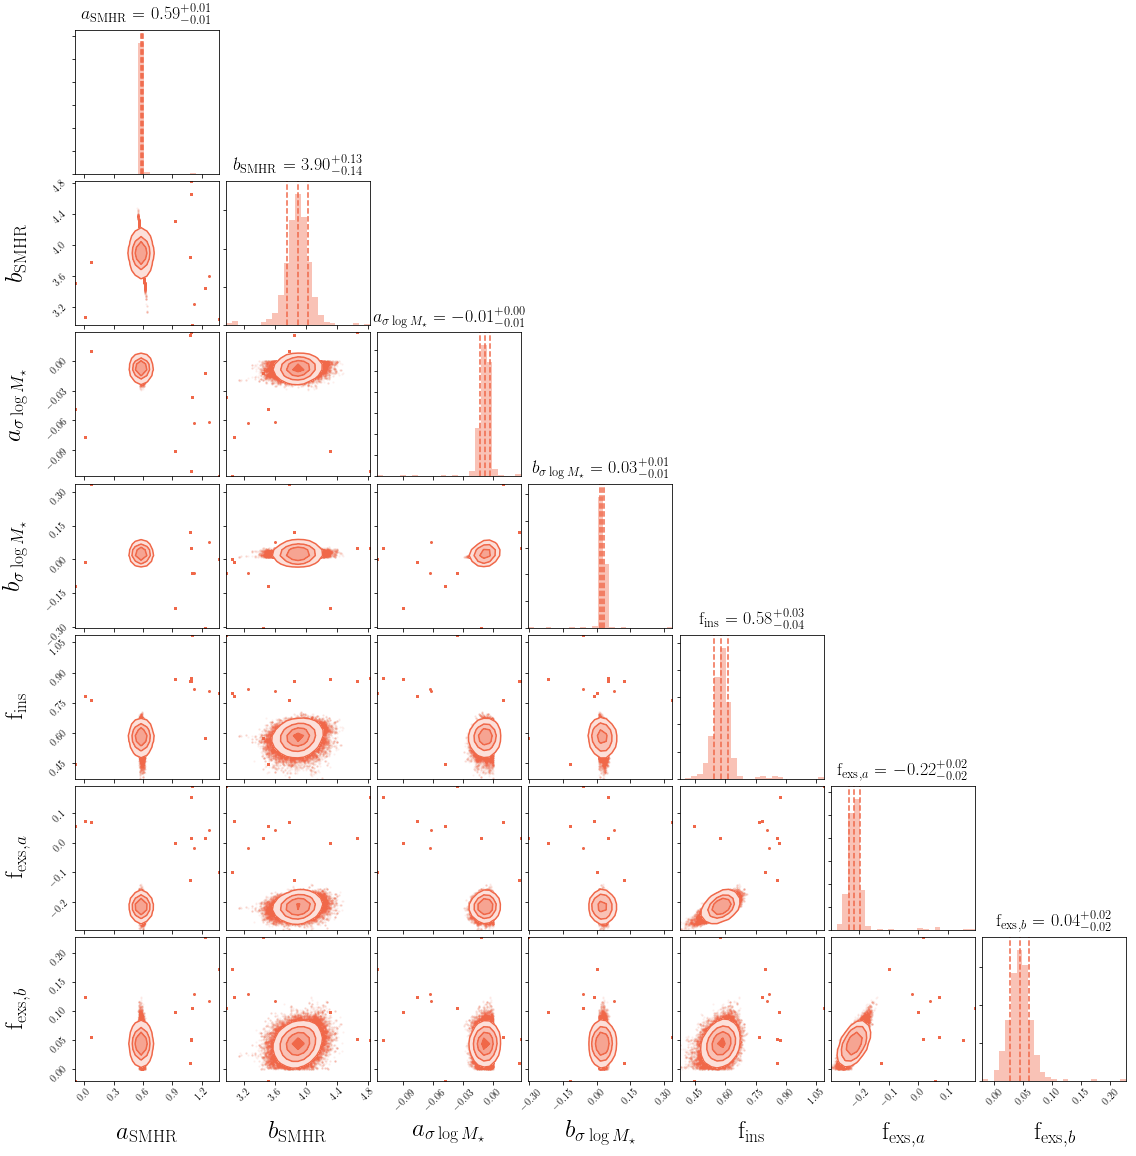

In [6]:
mod_corner = plot_mcmc_corner(mod_result_samples, cfg['mcmc_labels'])

#### Trace plot

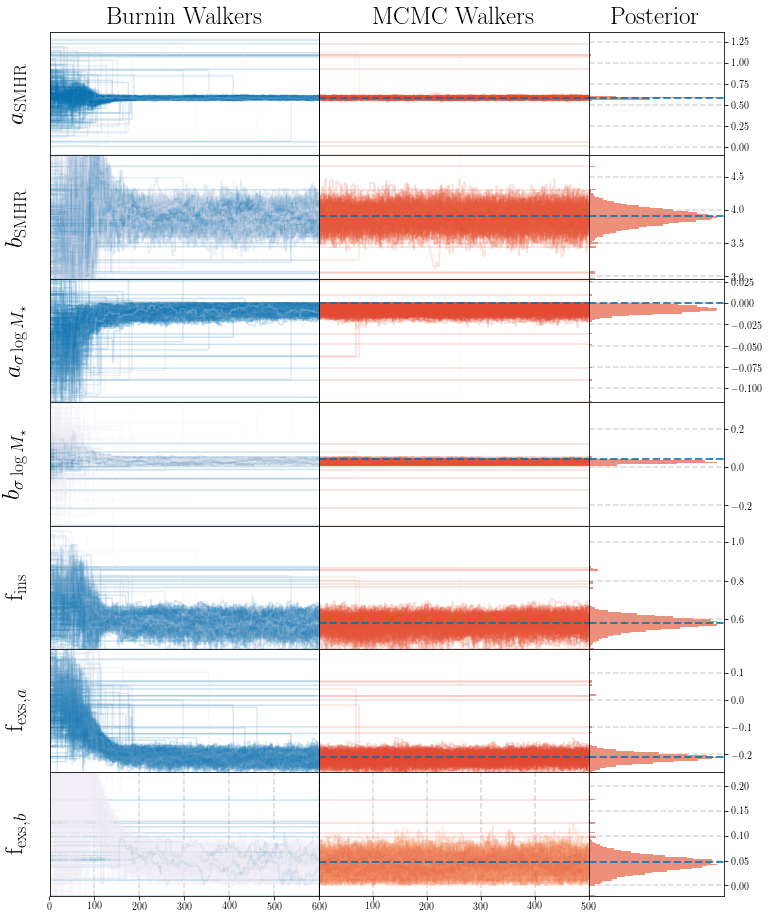

In [7]:
mod_trace = plot_mcmc_trace(mod_result_chains, 
                            cfg['mcmc_labels'],
                            mcmc_best=mod_result_best,
                            mcmc_burnin=mod_burnin_chains)

#### Best-fit model

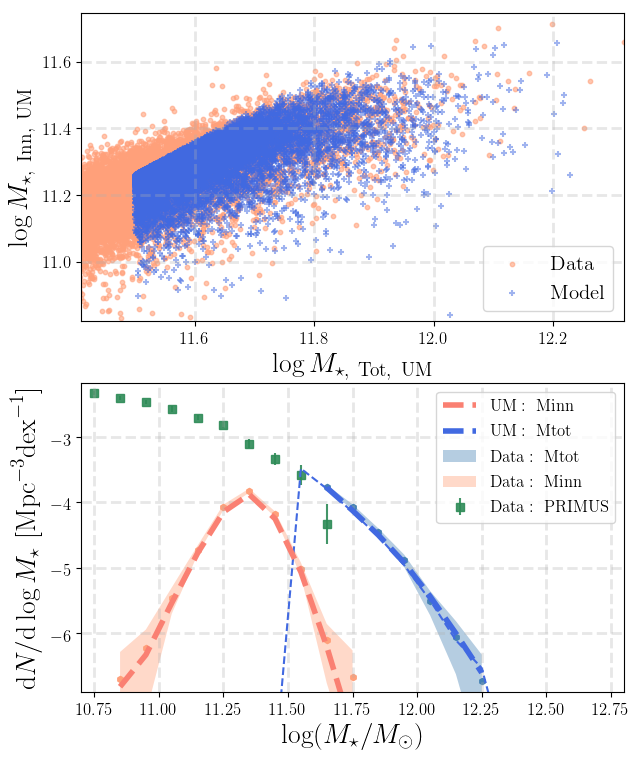

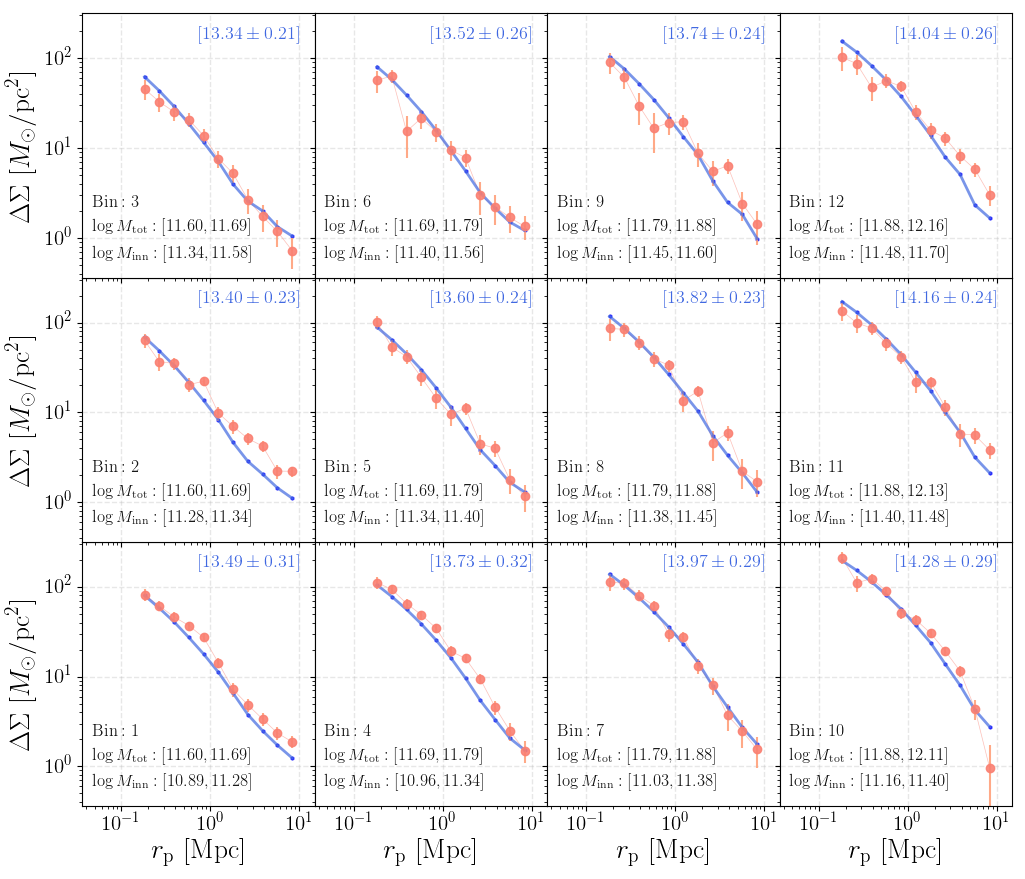

In [13]:
mod_model_prob = asap_predict_model_prob(mod_result_best, cfg, obs_data, um_data,  
                                         show_smf=True, show_dsigma=True, return_all=True)

um_smf_tot, um_smf_inn, um_dsigma, logms_mod_inn, logms_mod_tot, sig_logm, mask_tot = mod_model_prob

#### SMF plot with scatter included

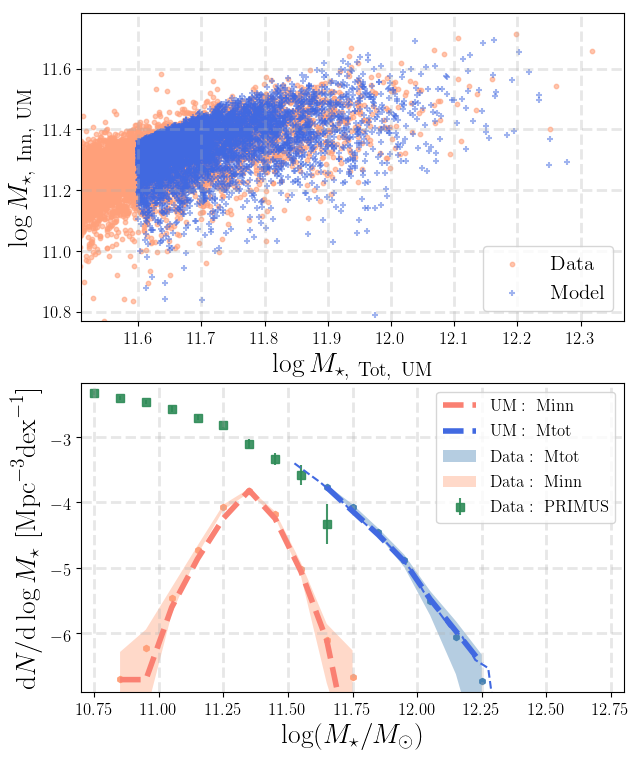

In [14]:
mod_model = asap_predict_model(mod_result_best, cfg, 
                               obs_data, um_data, show_smf=True, return_all=True)

(um_smf_tot, um_smf_inn, um_dsigma, 
 logms_inn_mod_all, logms_tot_mod_all, 
 logms_halo_mod_all, mask_tot) = mod_model

#### Iso-halo mass trend

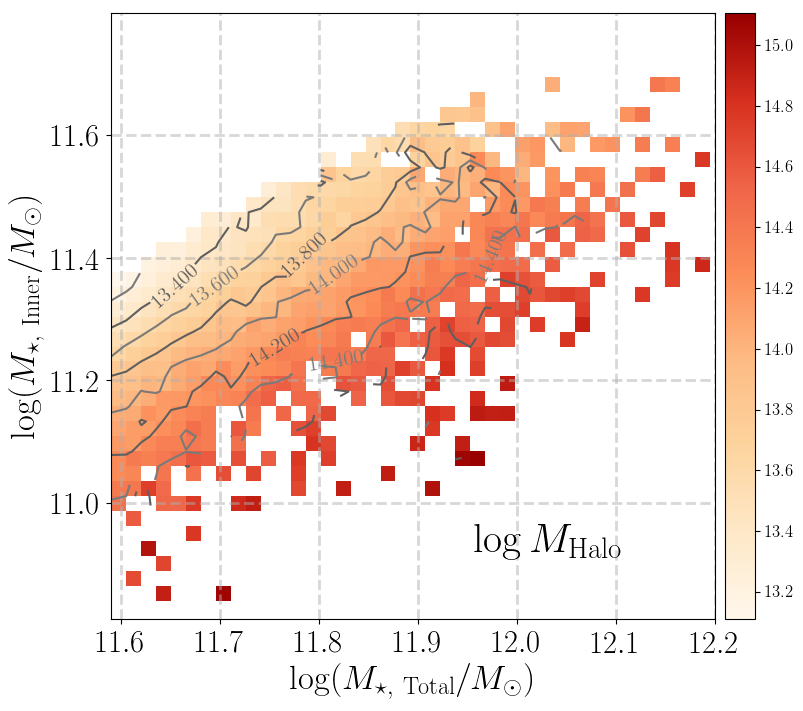

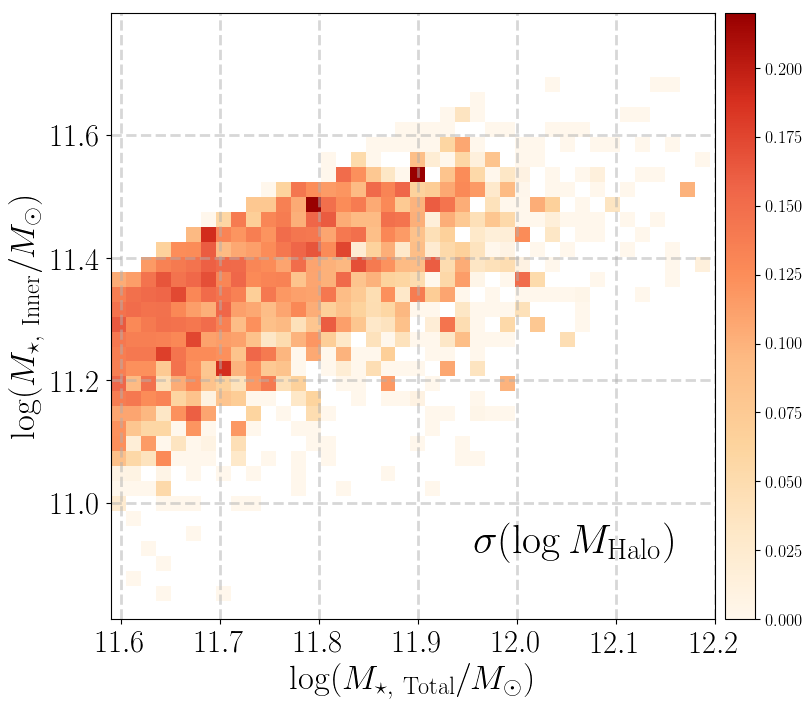

In [16]:
xx = logms_tot_mod_all
yy = logms_inn_mod_all
zz = um_mock['logmh_peak']

# Median halo mass
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.mean, 
                           x_bins=40, y_bins=35,
                           x_lim=[11.59, 12.2], y_lim=[10.81, 11.799],
                           n_contour=9)

# Scatter
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.nanstd, contour=False,
                           x_bins=40, y_bins=35,
                           x_lim=[11.59, 12.2], y_lim=[10.81, 11.799], 
                           title=r'$\sigma(\log M_{\mathrm{Halo}})$',
                           z_max=0.22)

#### Best-fit halo mass relation

In [31]:
shmr_a, shmr_b = mod_result_best[0], mod_result_best[1]
sigms_a, sigms_b = mod_result_best[2], mod_result_best[3]

mask_cen = um_mock['upid'] == -1
print(mask_cen.sum())

logmh_peak = um_mock['logmh_peak']
logmh_peak_cen = um_mock[mask_cen]['logmh_peak']

385125


Text(0,0.5,'$\\log M_{\\star, \\rm Total}$')

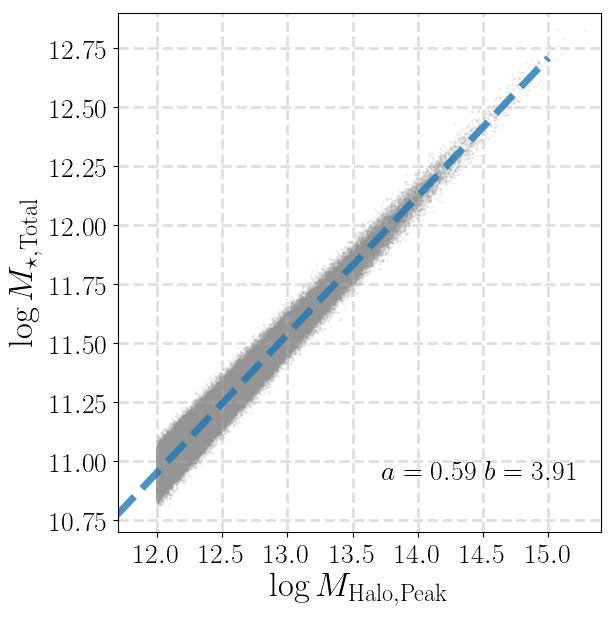

In [43]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.19, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

ax1.scatter(logmh_peak_cen, logms_halo_mod_all[mask_cen], s=1, c=BLK(0.5),
            alpha=0.1)
    
logmh_cen = np.linspace(11.5, 15.0, 50)
ax1.plot(logmh_cen, shmr_a * logmh_cen + shmr_b,
         linewidth=5.0, linestyle='--', alpha=0.8)

ax1.text(0.75, 0.09, r"$a=%5.2f\ b=%5.2f$" % (shmr_a, shmr_b),
         verticalalignment='bottom',
         horizontalalignment='center',
         fontsize=20,
         transform=ax1.transAxes)

ax1.set_xlim(11.7, 15.4)
ax1.set_ylim(10.7, 12.9)

ax1.set_xlabel(r'$\log M_{\mathrm{Halo, Peak}}$', fontsize=25)
ax1.set_ylabel(r'$\log M_{\star, \rm Total}$', fontsize=25)

Text(0,0.5,'$\\log M_{\\star, \\rm Central}$')

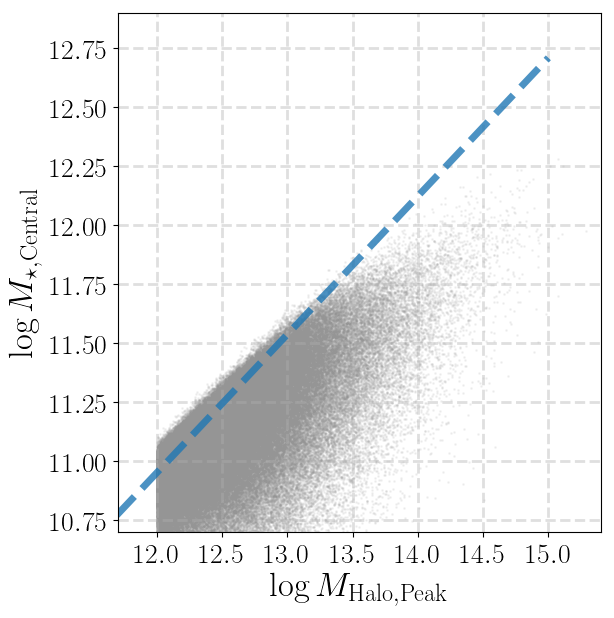

In [42]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.19, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

ax1.scatter(logmh_peak_cen, logms_tot_mod_all[mask_cen], s=1, c=BLK(0.5),
            alpha=0.1)
    
logmh_cen = np.linspace(11.5, 15.0, 50)
ax1.plot(logmh_cen, shmr_a * logmh_cen + shmr_b,
         linewidth=5.0, linestyle='--', alpha=0.8)

ax1.set_xlim(11.7, 15.4)
ax1.set_ylim(10.7, 12.9)

ax1.set_xlabel(r'$\log M_{\mathrm{Halo, Peak}}$', fontsize=25)
ax1.set_ylabel(r'$\log M_{\star, \rm Central}$', fontsize=25)

#### Best-fit halo mass - scatter relation

In [88]:
mask_cen = um_mock['upid'] == -1

logms_cen = logms_tot_mod_all[mask_cen]
logmh_cen = um_mock['logmh_peak'][mask_cen]

logms_all = logms_tot_mod_all
logmh_all = um_mock['logmh_peak']

logms_bin = np.linspace(11.5, 12.3, 8)
logmh_bin = np.linspace(13.0, 15.4, 8)

idx_logms_cen = np.digitize(logms_cen, logms_bin)
idx_logmh_cen = np.digitize(logmh_cen, logmh_bin)

idx_logms_all = np.digitize(logms_all, logms_bin)
idx_logmh_all = np.digitize(logmh_all, logmh_bin)

logms_mean = [np.nanmean(logms_all[idx_logms_all == k])
              for k in range(len(logms_bin))]
logmh_mean = [np.nanmean(logmh_all[idx_logmh_all == k])
              for k in range(len(logmh_bin))]

sigmh_cen = [np.nanstd(logmh_cen[idx_logms_cen == k])
             for k in range(len(logms_bin))]
sigmh_all = [np.nanstd(logmh_all[idx_logms_all == k])
             for k in range(len(logms_bin))]

sigms_cen = [np.nanstd(logms_cen[idx_logmh_cen == k])
             for k in range(len(logmh_bin))]
sigms_all = [np.nanstd(logms_all[idx_logmh_all == k])
             for k in range(len(logmh_bin))]

frac_cen = np.array([(np.sum(mask_cen[idx_logms_all == k]) * 1.0 /
                      (len(um_mock[idx_logms_all == k])))
                     for k in range(len(logms_bin))])

frac_sat = (1.0 - frac_cen) * 100.0

Text(0,0.5,'$\\sigma_{\\log M_{\\star, \\rm Halo}}$')

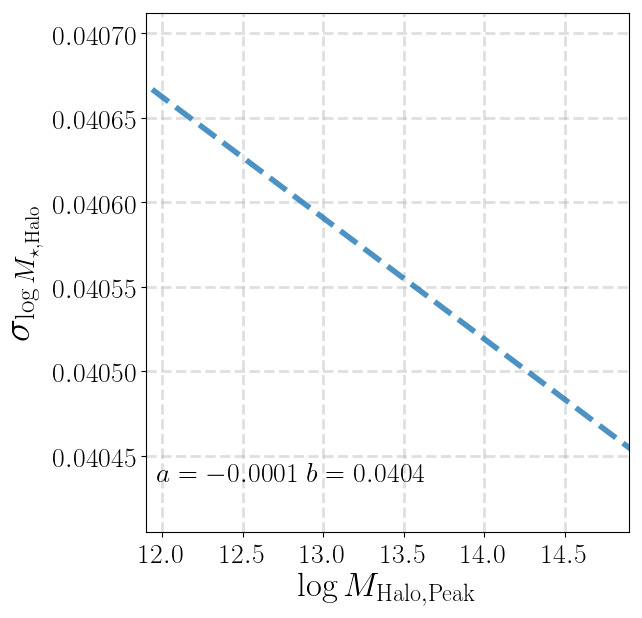

In [73]:
min_scatter = 0.01

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.19, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

logmh_cen = np.linspace(11.5, 15.4, 1000)
sig_ms = sigms_a * (np.asarray(logmh_cen) - 15.3) + sigms_b
sig_ms = np.where(sig_ms <= min_scatter, min_scatter, sig_ms)

ax1.plot(logmh_cen, sig_ms,
         linewidth=4.0, linestyle='--', alpha=0.8)

ax1.text(0.30, 0.09, r"$a=%7.4f\ b=%7.4f$" % (sigms_a, sigms_b),
         verticalalignment='bottom',
         horizontalalignment='center',
         fontsize=20,
         transform=ax1.transAxes)

ax1.set_xlim(11.9, 14.9)

ax1.set_xlabel(r'$\log M_{\mathrm{Halo, Peak}}$', fontsize=25)
ax1.set_ylabel(r'$\sigma_{\log M_{\star, \rm Halo}}$',
               fontsize=28)

Text(0,0.5,'$\\sigma_{\\log M_{\\star, \\rm Central}}$')

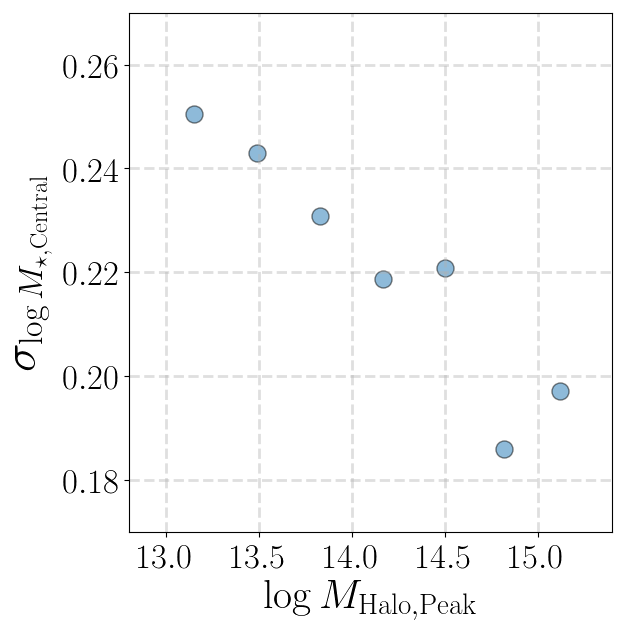

In [78]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.19, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax1.scatter(logmh_mean, sigms_cen, s=150, alpha=0.5, edgecolor='k')

ax1.set_xlim(12.8, 15.4)
ax1.set_ylim(0.17, 0.27)

ax1.set_xlabel(r'$\log M_{\mathrm{Halo, Peak}}$', fontsize=30)
ax1.set_ylabel(r'$\sigma_{\log M_{\star, \rm Central}}$',
               fontsize=35)

Text(0,0.5,'$\\sigma_{\\log M_{\\rm Halo,\\ Peak}}$')

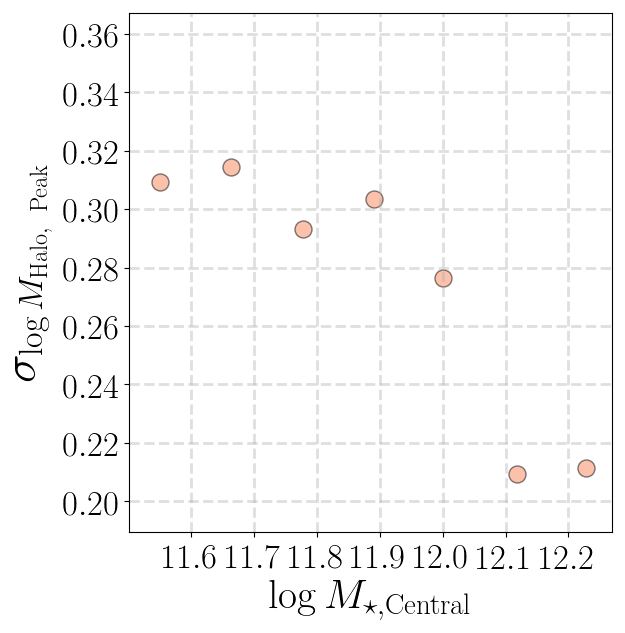

In [93]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.19, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax1.scatter(logms_mean, sigmh_all, c=ORG(0.6), 
            s=150, alpha=0.5, edgecolor='k')

ax1.set_xlim(11.501, 12.27)
#ax1.set_ylim(0.17, 0.27)

ax1.set_xlabel(r'$\log M_{\star, \mathrm{Central}}$', fontsize=30)
ax1.set_ylabel(r'$\sigma_{\log M_{\rm Halo,\ Peak}}$',
               fontsize=35)

#### Satellite fraction

Text(0,0.5,'$\\sigma_{\\log M_{\\rm Halo,\\ Peak}}$')

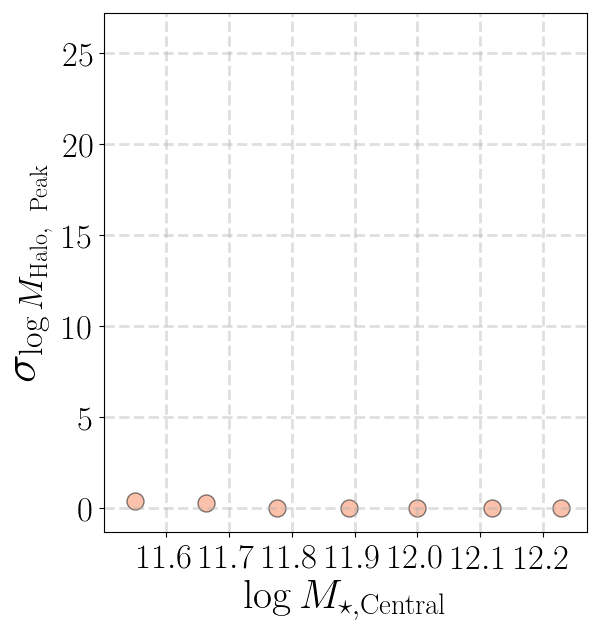

In [94]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.19, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax1.scatter(logms_mean, frac_sat, c=ORG(0.6), 
            s=150, alpha=0.5, edgecolor='k')

ax1.set_xlim(11.501, 12.27)
#ax1.set_ylim(0.17, 0.27)

ax1.set_xlabel(r'$\log M_{\star, \mathrm{Central}}$', fontsize=30)
ax1.set_ylabel(r'$\sigma_{\log M_{\rm Halo,\ Peak}}$',
               fontsize=35)